## Introduction

We illustrate the use of sensitivity analysis on the famous Lalonde data set. There are basically three different samples, one *experimental* and two *non-experimental* subsets. The samples have previously been used for sensitivity analysis, for example in Imbens (2003) and, more recently, in [Veitch and Zaveri (2020)](https://proceedings.neurips.cc/paper/2020/hash/7d265aa7147bd3913fb84c7963a209d1-Abstract.html).

A nice feature about the Lalonde data set is that makes it possible to compare the results from an experimental setting to an observational setting. Hence, we can compare the robustness of the results from an observational causal study to an experimental study, which is very unlikely affected by unobserved confounding. In this notebook, we basically replicate the sensitivity analysis in Imbens (2003) and [Veitch and Zaveri (2020)](https://proceedings.neurips.cc/paper/2020/hash/7d265aa7147bd3913fb84c7963a209d1-Abstract.html). A very nice notebook on the Lalonde data is also provided by [Yiqing Xu](https://yiqingxu.org/tutorials/lalonde/). 

The goal of the causal analysis is the evaluation of the *National Supported Work (NSW)* Demonstration, which is a labor market training program in the US. The program provides work experience for a period of up to 18 months to individuals with economic and social problems, with the aim to increase their labor market performance (for further empirical analyis of the data, see Chapter 4 of Huber (2023), for example).

## Data

We organize our analysis along the lines of Imbens (2003) and [Veitch and Zaveri (2020)](https://proceedings.neurips.cc/paper/2020/hash/7d265aa7147bd3913fb84c7963a209d1-Abstract.html) who consider (among others) two different sample specifications:

1. *Experimental Sample* - treated and control units randomly selected from the original experimental sample
2. *Lalonde Restricted Observational Sample* - selected sample of treated (148/185) and untreated (242/2490) units with individual earnings in 1975 and 1975 below $\$5000$.
3. *Lalonde Unrestriced Observational Sample* - treated from experimental sample and controls from full set of PSID observations.

The original data files are available from the supplemental material of [Veitch and Zaveri (2020)](https://proceedings.neurips.cc/paper/2020/hash/7d265aa7147bd3913fb84c7963a209d1-Abstract.html).

The data set contains nine covariates

* married
* age
* indicators for black and Hispanic,
* years of education
* (real) earnings in 1974 and 1975,
* and indicators for positive earnings in 1974 and 1975

and the outcome (earnings in 1978). The treatment variable is an indicator for participation in the job training program.

### 1. Experimental Sample

In [14]:
import pandas as pd

lalonde_exp = pd.read_csv('https://trainings.doubleml.org/datasets/imbens1.csv')
lalonde_exp.shape

(445, 11)

### 2. Restricted Sample

In [15]:
lalonde_restricted = pd.read_csv('https://trainings.doubleml.org/datasets/imbens4.csv')
lalonde_restricted.shape

(390, 11)

### 3. Unrestricted Sample

In [16]:
lalonde_nonexp = pd.read_csv('https://trainings.doubleml.org/datasets/imbens2.csv')
lalonde_nonexp.shape

(2675, 11)

We will start estimating the causal effect of NSW based on the observational sample first. To address selection-into-treatment mechanisms that would invalidate the unconfoundedness assumption, we perform a sensitivity analysis based on the observational samples. We will then re-examine the analysis based on the experimental sample and then see to what extent can be replicated using a restricted observational sample.

### Brief Summary Statistics

We mainly consider past earnings as a benchmark variable. To see the difference across the experimental and non-experimental samples, we plot the distribution of past earnings for the treated and control units.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
colors = sns.color_palette()
plt.rcParams['figure.figsize'] = 6., 4
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'axes.spines.top': False,
                            'axes.spines.bottom': False,
                            'axes.spines.left': False,
                            'axes.spines.right': False})

treatment
0.0    Axes(0.08,0.07;0.87x0.81)
1.0    Axes(0.08,0.07;0.87x0.81)
Name: RE75, dtype: object

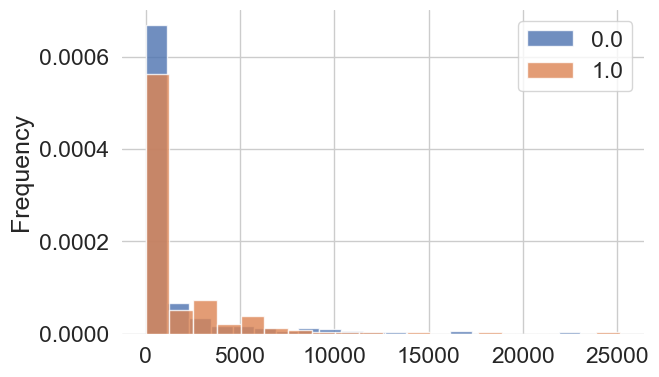

In [18]:
# Experimental sample
lalonde_exp.groupby('treatment')['RE75'].plot.hist(bins = 20, alpha = 0.8, density = True, legend = True)

treatment
0.0    Axes(0.08,0.07;0.87x0.81)
1.0    Axes(0.08,0.07;0.87x0.81)
Name: RE75, dtype: object

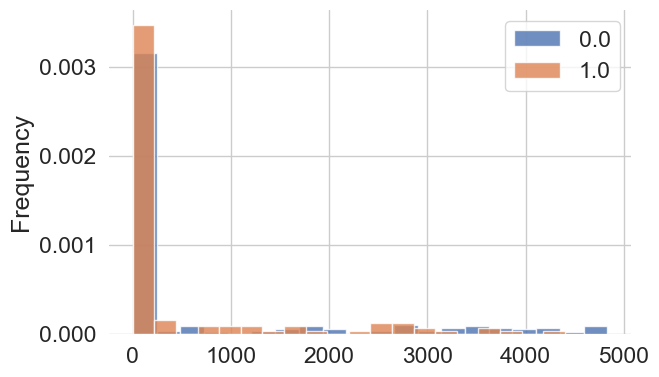

In [19]:
# Experimental sample
lalonde_restricted.groupby('treatment')['RE75'].plot.hist(bins = 20, alpha = 0.8, density = True, legend = True)

treatment
0.0    Axes(0.08,0.07;0.87x0.81)
1.0    Axes(0.08,0.07;0.87x0.81)
Name: RE75, dtype: object

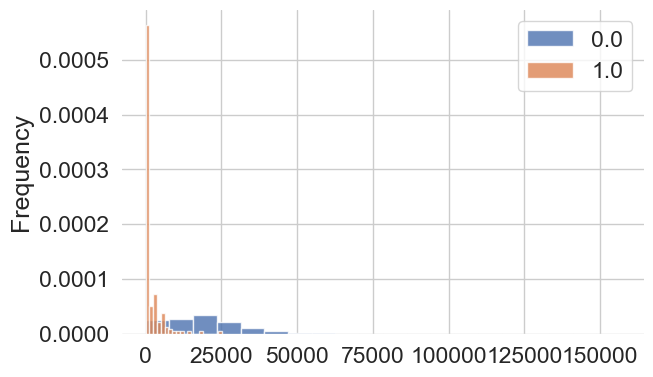

In [20]:
lalonde_nonexp.groupby('treatment')['RE75'].plot.hist(bins = 20, alpha = 0.8, density = True, legend = True)

## Causal Estimation: Partially Linear Regression

We will first estimate the Average Treatment Effect (ATE) of the training on earnings using a partially linear regression model.

In [21]:
from causalml.match import NearestNeighborMatch
from causalml.inference.meta import BaseXLearner
from causalml.inference.meta import BaseTLearner
from causalml.inference.meta import BaseRLearner
from causalml.inference.meta import TMLELearner
import statsmodels.formula.api as smf

import os
import datetime
import time
import warnings
#from mpi4py import MPI
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression
)
from lightgbm import LGBMClassifier, LGBMRegressor
import doubleml as dml
import utils_calibration
import utils_dgps
from utils_calibration import (
    calibrate_propensity_score, 
    compute_ipw_wls,
    calibration_errors
)
from utils_dgps import dgp_wrapper

ImportError: cannot import name 'compute_ipw_wls' from 'utils_calibration' (c:\Users\janra\OneDrive\Documents\GitHub\Propensity-Calibration-Guidebook\run-simulation\py-files\utils_calibration.py)

### Data Backend

In [ ]:
x_cols = lalonde_exp.columns.drop(['RE78', 'treatment']).to_list()

dml_data_nonexp = dml.DoubleMLData(lalonde_nonexp, y_col='RE78',
                          d_cols='treatment',
                          x_cols=x_cols)

In [ ]:

dml_data_exp = dml.DoubleMLData(lalonde_exp, y_col='RE78',
                          d_cols='treatment',
                          x_cols=x_cols)

In [ ]:
dml_data_restricted = dml.DoubleMLData(lalonde_restricted, y_col='RE78',
                          d_cols='treatment',
                          x_cols=x_cols)

## References

- Huber, Martin. 2023. *Causal Analysis: Impact Evaluation and Causal Machine Learning with Applications in r*. MIT Press.
- Imbens, Guido W. 2003. “Sensitivity to Exogeneity Assumptions in Program Evaluation.” American Economic Review 93 (2): 126–32.
- Veitch, Victor, and Anisha Zaveri. 2020. “Sense and Sensitivity Analysis: Simple Post-Hoc Analysis of Bias Due to Unobserved Confounding.” Advances in Neural Information Processing Systems 33: 10999–1009.


# Calibration

In [ ]:
from causalml.match import NearestNeighborMatch
from causalml.inference.meta import BaseXLearner
from causalml.inference.meta import BaseTLearner
from causalml.inference.meta import BaseRLearner
from causalml.inference.meta import TMLELearner
import statsmodels.formula.api as smf

import os
import datetime
import time
import warnings
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression
)
from lightgbm import LGBMClassifier, LGBMRegressor

import sys
from pathlib import Path

project_root = (
    Path.cwd()
    .parents[0]
)
sys.path.append(str(project_root/'run-simulation'/'py-files'))

import doubleml as dml
from utils_ate import (
    calibrate_propensity_score, 
    compute_ipw_wls,
    calibration_errors,
    compute_ci_metrics,
    create_results_dict
)

### Load the data sets

In [ ]:
lalonde_exp = pd.read_csv('https://trainings.doubleml.org/datasets/imbens1.csv')
lalonde_nonexp = pd.read_csv('https://trainings.doubleml.org/datasets/imbens2.csv')
lalonde_restricted = pd.read_csv('https://trainings.doubleml.org/datasets/imbens4.csv')

### Estimation setup

In [ ]:
def estimate_ate(data, theta, learner_g, learner_m, n_folds, score, clipping_thresholds, calib_methods, m_0):

    n_calib_methods = len(calib_methods)
    n_clipping_thresholds = len(clipping_thresholds)

    # Base array with shape (n_calib_methods, n_clipping_thresholds)
    irm_coefs = np.full((n_calib_methods, n_clipping_thresholds), np.nan)

    # Create multiple arrays of the same shape and fill value (np.nan)
    irm_ses, irm_cover, irm_ci_length, K, rmses, ece_u, ece_q, ece_u_5, ece_q_5, mce, ece_l2, ipw_coefs, ipw_ses, ipw_ci_length,ipw_cover, plr_coefs, plr_ses,plr_ci_length,plr_cover = [
        np.full_like(irm_coefs, np.nan) for _ in range(19)
    ]

    # Arrays with the string "not specified" and object dtype
    name_calib_method, name_method = [
        np.full_like(irm_coefs, "not specified", dtype=object) for _ in range(2)
    ]

    # Create arrays for match_* variables with shape (n_clipping_thresholds,)
    match_coefs = np.full((n_calib_methods, n_clipping_thresholds), np.nan)
    match_ses,match_ci_length, match_cover, K_match, rmses_match, ece_u_match, ece_q_match, ece_u_5_match, ece_q_5_match, mce_match, ece_l2_match = [
        np.full_like(match_coefs, np.nan) for _ in range(11)
    ]

    # Create arrays for meta learners variables with shape (n_clipping_thresholds,)
    X_coefs = np.full((n_calib_methods, n_clipping_thresholds), np.nan)
    X_ci_length, X_cover, TMLE_coefs, TMLE_ci_length, TMLE_cover,  = [
        np.full_like(X_coefs, np.nan) for _ in range(5)
    ]

    # set up the DoubleMLIRM models
    dml_irm = dml.DoubleMLIRM(data,
                            ml_g=learner_g,
                            ml_m=learner_m,
                            score=score,
                            n_folds=n_folds,
                            trimming_threshold=1e-12) 
    # fit standard model without calibration and save predictions
    dml_irm.fit(n_jobs_cv=5)
    smpls = dml_irm.smpls[0]
    dml_irm_ext = dml.DoubleMLIRM(data,
                                ml_g=dml.utils.DMLDummyRegressor(),
                                ml_m=dml.utils.DMLDummyClassifier(),
                                score=score,
                                n_folds=n_folds,
                                trimming_threshold=1e-12)
    # set up the PLR model
    dml_plr = dml.DoubleMLPLR(data,
                              ml_l=learner_g,
                              ml_m=learner_m,
                              score="partialling out",
                              n_folds=n_folds)
    dml_plr.fit(n_jobs_cv=5)
    dml_plr_ext = dml.DoubleMLPLR(data,
                                  ml_l=dml.utils.DMLDummyRegressor(),
                                  ml_m=dml.utils.DMLDummyClassifier(),
                                  score="partialling out",
                                  n_folds=n_folds)

    prop_score = dml_irm.predictions["ml_m"][:, :, 0].squeeze()
    treatment = data.d
    outcome = data.y
    covariates = data.x

    for i_clipping_threshold, clipping_threshold in enumerate(clipping_thresholds):                 

        # re-fit model with calibration
        for i_calib_method, (method, calib_method) in enumerate(calib_methods):
            method = method
            calib_method = calib_method
            calib_prop_score = calibrate_propensity_score(
                method=method,
                covariates=covariates,
                propensity_score=prop_score, 
                treatment=treatment, 
                learner_m=learner_m,
                calib_method=calib_method,
                clipping_threshold=clipping_threshold,
                smpls=smpls,
                true_propensity_score=None)
            
            df_X = pd.DataFrame(covariates, columns=[f'x_{i}' for i in range(covariates.shape[1])]) 

            df_pred = pd.DataFrame({
            'd': treatment,
            'y': outcome,
            'prop_score': np.clip(calib_prop_score, 
                                0.0 + clipping_threshold, 
                                1.0 - clipping_threshold)
            })
            df_pred = pd.concat([df_pred, df_X], axis=1)
            
            # Perform nearest neighbor matching using causalml
            psm = NearestNeighborMatch(
                caliper=0.001,  # Equivalent to your threshold parameter
                replace=False,
                ratio=1,
                random_state=42,
                n_jobs = -1
            )
            
            # Perform matching using external propensity scores
            matched_data = psm.match(
                data=df_pred,
                treatment_col='d',
                score_cols=['prop_score'],
            )
            
            
            # Estimate ATE with OLS
            covariates_list = [str(col) for col in df_X.columns]  # Assuming df_X is your covariate DataFrame
            model_formula = f'y ~ d + {" + ".join(covariates_list)}'
            model = smf.ols(model_formula, data=matched_data).fit()      
            # Store results
            match_coefs[i_calib_method,i_clipping_threshold] = model.params['d']
            match_ses[i_calib_method,i_clipping_threshold] = model.bse['d']

            confint = model.conf_int(alpha=0.05)

            # Calculate the length of the confidence interval for 'd'
            match_ci_length[i_calib_method,i_clipping_threshold] = confint.loc['d', 1] - confint.loc['d', 0]

            # Check coverage: See if the true treatment effect theta is within the confidence interval for 'd'
            match_cover[i_calib_method,i_clipping_threshold] = (confint.loc['d', 0] < theta) and (theta < confint.loc['d', 1])
        
            # Store propensity scores for calibration metrics
            prop_score_match = matched_data['prop_score'].values
            y_match = matched_data['y'].values
            d_match = matched_data['d'].values
            X_match = matched_data[df_X.columns].values

            ece_u_match[i_calib_method,i_clipping_threshold] = calibration_errors(prop_score_match, d_match, 
                                                                                        strategy = 'uniform',norm='l1',n_bins= float(10))
            ece_q_match[i_calib_method,i_clipping_threshold] = calibration_errors(prop_score_match, d_match,
                                                                                        strategy = 'quantile',norm='l1',n_bins= float(10))
            ece_u_5_match[i_calib_method,i_clipping_threshold] = calibration_errors(prop_score_match, d_match, 
                                                                                        strategy = 'uniform',norm='l1',n_bins= float(5))
            ece_q_5_match[i_calib_method,i_clipping_threshold] = calibration_errors(prop_score_match, d_match,
                                                                                        strategy = 'quantile',norm='l1',n_bins= float(5))            
            ece_l2_match[i_calib_method,i_clipping_threshold] = calibration_errors(prop_score_match, d_match,
                                                                            strategy = 'uniform',norm='l2',n_bins= float(10))
            mce_match[i_calib_method,i_clipping_threshold] = calibration_errors(prop_score_match, d_match,
                                                                                    strategy = 'uniform',norm='max',n_bins= float(10))
            # store n-unique propensity scores
            prop_values, inverse_map, counts = np.unique(prop_score_match, return_inverse=True, return_counts=True)
            K_match[i_calib_method,i_clipping_threshold] = len(prop_values)
            rmses_match[i_calib_method,i_clipping_threshold] = np.sqrt(((prop_score_match -  d_match) ** 2).mean())


            # Add X Learner, TMLE Learner

            #[X_coefs[i_calib_method,i_clipping_threshold], X_lower, X_upper] = BaseXLearner(learner=learner_g).estimate_ate(X=df_X, treatment=df_pred['d'], 
            #                                                                                                y=df_pred['y'],p=df_pred['prop_score'],
            #                                                                                                bootstrap_ci=True, n_bootstraps =100)
            #X_ci_length[i_calib_method,i_clipping_threshold], X_cover[i_calib_method,i_clipping_threshold] = compute_ci_metrics(theta, X_lower, X_upper).values()

            [TMLE_coefs[i_calib_method,i_clipping_threshold], TMLE_lower, TMLE_upper] = TMLELearner(learner=learner_g,calibrate_propensity=False).estimate_ate(X=df_X, treatment=df_pred['d'], 
                                                                                                                    y=df_pred['y'],p=df_pred['prop_score'],
                                                                                                                    return_ci =True)
            TMLE_ci_length[i_calib_method,i_clipping_threshold], TMLE_cover[i_calib_method,i_clipping_threshold] = compute_ci_metrics(theta, TMLE_lower, TMLE_upper).values() 

            #[T_coefs[i_calib_method,i_clipping_threshold], T_lower, T_upper] = BaseTLearner(learner=learner_g).estimate_ate(X=df_X, treatment=df_pred['d'],
            #                                                                                                                y=df_pred['y'],p=df_pred['prop_score'],bootstrap_ci =True)
            #T_ci_length[i_calib_method,i_clipping_threshold], T_cover[i_calib_method,i_clipping_threshold] = compute_ci_metrics(theta, T_lower, T_upper).values() 
            #[R_coefs[i_calib_method,i_clipping_threshold], R_lower, R_upper] = BaseRLearner(learner=learner_g).estimate_ate(X=df_X, treatment=df_pred['d'],
            #                                                                                                                y=df_pred['y'],p=df_pred['prop_score'],bootstrap_ci =True)  
            #R_ci_length[i_calib_method,i_clipping_threshold], R_cover[i_calib_method,i_clipping_threshold] = compute_ci_metrics(theta, R_lower, R_upper).values() 

            # fit irm model with external predictions
            pred_dict_irm_calib = {"d": {
                "ml_g0": dml_irm.predictions["ml_g0"][:, :, 0],
                "ml_g1": dml_irm.predictions["ml_g1"][:, :, 0],
                "ml_m": calib_prop_score.reshape(-1, 1),
                }
            }
            dml_irm_ext.fit(external_predictions=pred_dict_irm_calib)
            
            # fit plr model with external predictions
            pred_dict_plr_calib = {"d": {
                "ml_l": dml_plr.predictions["ml_l"][:, :, 0],
                "ml_m": calib_prop_score.reshape(-1, 1),
                }
            }
            dml_plr_ext.fit(external_predictions=pred_dict_plr_calib)

            irm_coefs[i_calib_method, i_clipping_threshold] = dml_irm_ext.coef[0]
            irm_ses[i_calib_method, i_clipping_threshold] = dml_irm_ext.se[0]
            irm_confint_calib = dml_irm_ext.confint()
            irm_cover[i_calib_method, i_clipping_threshold] = (irm_confint_calib.loc['d', '2.5 %'] < theta) & (theta < irm_confint_calib.loc['d', '97.5 %'])
            irm_ci_length[i_calib_method, i_clipping_threshold]  = irm_confint_calib.loc['d', '97.5 %'] - irm_confint_calib.loc['d', '2.5 %']
            rmses[i_calib_method, i_clipping_threshold] = np.sqrt(((calib_prop_score - treatment) ** 2).mean())
            name_method[i_calib_method, i_clipping_threshold] = method
            name_calib_method[i_calib_method, i_clipping_threshold] = calib_method
            ece_u[i_calib_method, i_clipping_threshold] = calibration_errors(calib_prop_score, treatment, 
                                                                                     strategy = 'uniform',norm='l1',n_bins= float(10))
            ece_q[i_calib_method, i_clipping_threshold] = calibration_errors(calib_prop_score, treatment,
                                                                                     strategy = 'quantile',norm='l1',n_bins= float(10))
            ece_u_5[i_calib_method, i_clipping_threshold] = calibration_errors(calib_prop_score, treatment, 
                                                                                     strategy = 'uniform',norm='l1',n_bins= float(5))
            ece_q_5[i_calib_method, i_clipping_threshold] = calibration_errors(calib_prop_score, treatment,
                                                                                     strategy = 'quantile',norm='l1',n_bins= float(5))            
            ece_l2[i_calib_method, i_clipping_threshold] = calibration_errors(calib_prop_score, treatment,
                                                                                      strategy = 'uniform',norm='l2',n_bins= float(10))
            mce[i_calib_method, i_clipping_threshold] = calibration_errors(calib_prop_score, treatment,
                                                                                   strategy = 'uniform',norm='max',n_bins= float(10))
            # store n-unique propensity scores
            prop_values, inverse_map, counts = np.unique(calib_prop_score, return_inverse=True, return_counts=True)
            K[i_calib_method, i_clipping_threshold] = len(prop_values)
            ipw = compute_ipw_wls(calib_prop_score, treatment, outcome,theta)

            ipw_coefs[i_calib_method, i_clipping_threshold] = ipw['IPW_coefs']
            ipw_ses[i_calib_method, i_clipping_threshold] = ipw['IPW_ses']
            ipw_ci_length[i_calib_method, i_clipping_threshold] = ipw['IPW_ci_length']
            ipw_cover[i_calib_method, i_clipping_threshold] = ipw['IPW_cover']
            plr_coefs[i_calib_method, i_clipping_threshold] = dml_plr_ext.coef[0]
            plr_ses[i_calib_method, i_clipping_threshold] = dml_plr_ext.se[0]
            plr_confint_calib = dml_plr_ext.confint()
            plr_cover[i_calib_method, i_clipping_threshold] = (plr_confint_calib.loc['d', '2.5 %'] < theta) & (theta < plr_confint_calib.loc['d', '97.5 %'])
            plr_ci_length[i_calib_method, i_clipping_threshold]  = plr_confint_calib.loc['d', '97.5 %'] - plr_confint_calib.loc['d', '2.5 %']

    # Define common metrics structure
    METRICS = [
        "irm_coefs", "irm_ses", "irm_cover", "irm_ci_length",
        "K", "rmses", "method", "calib_method",
        "ipw_coefs", "ipw_ses", "ipw_cover", "ipw_ci_length",
        "plr_coefs", "plr_ses", "plr_cover", "plr_ci_length",
        "ece_u", "ece_q", "ece_u_5", "ece_q_5", "ece_l2", "mce",
        "match_coefs", "match_ses", "match_ci_length", "match_cover",
        "X_coefs", "X_ci_length", "X_cover", 
        "TMLE_coefs", "TMLE_ci_length", "TMLE_cover"
    ]
    
    n_calib_methods = len(calib_methods)
    n_clipping_thresholds = len(clipping_thresholds)
    base_shape = (n_calib_methods, n_clipping_thresholds)
    results_dict_calib = create_results_dict(
        base_shape=(n_calib_methods, n_clipping_thresholds),
        fill_data={
            "irm_coefs": irm_coefs,
            "irm_ses": irm_ses,
            "irm_cover": irm_cover,
            "irm_ci_length": irm_ci_length,
            "K": K,
            "rmses": rmses,
            "method": name_method,
            "calib_method": name_calib_method,
            "ipw_coefs": ipw_coefs,
            "ipw_ses": ipw_ses,
            "ipw_cover": ipw_cover,
            "ipw_ci_length": ipw_ci_length,
            "plr_coefs": plr_coefs,
            "plr_ses": plr_ses,
            "plr_cover": plr_cover,
            "plr_ci_length": plr_ci_length,
            "ece_u": ece_u,
            "ece_q": ece_q,
            "ece_u_5": ece_u_5,
            "ece_q_5": ece_q_5,        
            "ece_l2": ece_l2,        
            "mce": mce
        },
        metrics_dict=METRICS,
    )

    results_dict_match = create_results_dict(
        base_shape=(n_calib_methods, n_clipping_thresholds),
        fill_data={
            "K": K_match,  
            "rmses": rmses_match,
            "method": name_method,
            "calib_method": name_calib_method,
            "ece_u": ece_u_match,
            "ece_q": ece_q_match,
            "ece_u_5": ece_u_5_match,
            "ece_q_5": ece_q_5_match,
            "ece_l2": ece_l2_match,
            "mce": mce_match,
            "match_coefs": match_coefs,
            "match_ses": match_ses,
            "match_ci_length": match_ci_length,
            "match_cover": match_cover
        },
        metrics_dict=METRICS
    )

    results_dict_meta = create_results_dict(
        base_shape=(n_calib_methods, n_clipping_thresholds),
        fill_data={
            "method": name_method,
            "calib_method": name_calib_method,
            "X_coefs": X_coefs,
            "X_ci_length": X_ci_length,
            "X_cover": X_cover,
            "TMLE_coefs": TMLE_coefs,
            "TMLE_ci_length": TMLE_ci_length,
            "TMLE_cover": TMLE_cover
        },
        metrics_dict=METRICS
    )

    return results_dict_calib, results_dict_match, results_dict_meta


In [ ]:
clipping_thresholds = [1e-12, 0.01, 0.1]

calib_methods = [
    ('alg-1-uncalibrated', 'uncalibrated'),
    #('alg-3-cross-fitted-calib', 'isotonic'),
    #('alg-3-cross-fitted-calib', 'platt'),
    #('alg-3-cross-fitted-calib', 'ivap'),
    ('alg-5-full-sample-calib', 'isotonic'),
    ('alg-5-full-sample-calib', 'platt'),
    ('alg-5-full-sample-calib', 'ivap'),
    #('oracle', 'uncalibrated')
]

In [ ]:
n_folds = 5
score = "ATE"

theta = 1794.34 

learner_dict_g = {
    'Linear': LinearRegression(),
    #'RF': RandomForestRegressor(random_state=None),
    'LGBM': LGBMRegressor(verbose=-1, random_state=None),
    }

learner_dict_m = {
    'Logit': LogisticRegression(),
    #'RF': RandomForestClassifier(random_state=None),
    'LGBM': LGBMClassifier(verbose=-1, random_state=None),
    }
i_rep = 0
R2_d = 0 

In [ ]:
result_dfs = {}

for i, df_lalonde in enumerate([lalonde_exp, lalonde_nonexp, lalonde_restricted], start=1):

    df = pd.DataFrame(columns=[
    "irm_coefs", "irm_ses", "irm_cover", "irm_ci_length", "K", "rmses", "method", "calib_method",
    "ipw_coefs","ipw_ses", "ipw_cover", "ipw_ci_length", "plr_coefs","plr_ses", "plr_cover", "plr_ci_length",
    "match_coefs","match_ses", "match_ci_length","match_cover", 
    "X_coefs", "X_ci_length", "X_cover", "TMLE_coefs", "TMLE_ci_length", "TMLE_cover",
    "learner_g", "learner_m", "n_obs", "dim_x", "R2_d", "clipping_threshold", "repetition",
    "ece_u", "ece_q", "ece_u_5", "ece_q_5", "ece_l2", "mce"])

    x_cols = df_lalonde.columns.drop(['RE78', 'treatment']).to_list()
    df_lalonde.rename(columns={'RE78': 'y', 'treatment': 'd'}, inplace=True)
    x_cols = df_lalonde.columns.drop(['y', 'd']).to_list()


    dml_data = dml.DoubleMLData(df_lalonde, y_col='y',
                            d_cols='d',
                            x_cols=x_cols)

    n_obs = df_lalonde.shape[0]
    dim_x = len(x_cols)
    dml_data = dml_data
    m_0 = None
    for i_learner_g, (name_learner_g, learner_g) in enumerate(learner_dict_g.items()):
        for i_learner_m, (name_learner_m, learner_m) in enumerate(learner_dict_m.items()):
            random_state_value = 42 + i_rep
            if hasattr(learner_m, 'random_state'):
                learner_m.random_state = random_state_value
            if hasattr(learner_g, 'random_state'):
                learner_g.random_state = random_state_value

            results_dict_calib, results_dict_match, results_dict_meta = estimate_ate(
                dml_data, theta, learner_g, learner_m, n_folds, score, clipping_thresholds, calib_methods, m_0
            )

            result_columns = [
                "irm_coefs", "irm_ses", "irm_cover", "irm_ci_length", "K", "rmses",
                "method", "calib_method", "ipw_coefs", "ipw_ses", "ipw_cover", "ipw_ci_length",
                "plr_coefs", "plr_ses", "plr_cover", "plr_ci_length",
                "match_coefs", "match_ses", "match_ci_length", "match_cover",
                "X_coefs", "X_ci_length", "X_cover", "TMLE_coefs", "TMLE_ci_length", "TMLE_cover",
                "ece_u", "ece_q", "ece_u_5", "ece_q_5", "ece_l2", "mce"
            ]

            common_metadata = {
                "learner_g": name_learner_g,
                "learner_m": name_learner_m,
                "n_obs": n_obs,
                "dim_x": dim_x,
                "R2_d": 0,
                "repetition": 0         
            }
            n_calib_methods = len(calib_methods)
            n_clipping_thresholds = len(clipping_thresholds)
            
            for i_clipping, clipping_threshold in enumerate(clipping_thresholds):
                for results in [results_dict_calib, results_dict_match, results_dict_meta]:
                    # Process calibration results
                    result_data = {
                        col: results[col][:, i_clipping]  # 1D slice
                        for col in result_columns
                    }
                    result_data.update({
                        k: np.full(n_calib_methods, v) 
                        for k, v in common_metadata.items()
                    })
                    result_data["clipping_threshold"] = clipping_threshold
                    df = pd.concat([df, pd.DataFrame(result_data)], ignore_index=True)
    result_dfs[f'df_lalonde_{i}'] = df 

In [ ]:
df_lalonde_exp = result_dfs['df_lalonde_1']
df_lalonde_nonexp = result_dfs['df_lalonde_2']
df_lalonde_restricted = result_dfs['df_lalonde_3']
df_lalonde_exp.to_pickle(f'{project_root}/evaluate-results/results/df_lalonde_exp.pkl')
df_lalonde_nonexp.to_pickle(f'{project_root}/evaluate-results/results/df_lalonde_nonexp.pkl')
df_lalonde_restricted.to_pickle(f'{project_root}/evaluate-results/results/df_lalonde_restricted.pkl')